In [1]:
import pandas as pd
import numpy as np
import helper
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import matplotlib.pyplot as plt
import re
import datetime

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from googletrans import Translator

In [2]:
data = pd.read_csv('daily8_4.csv')
#import data with sentiment analysis

In [3]:
data.info()
#snapshot of df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276181 entries, 0 to 276180
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           276181 non-null  int64  
 1   id              276181 non-null  object 
 2   url             276181 non-null  object 
 3   headline        276181 non-null  object 
 4   dateline        276181 non-null  object 
 5   text            276181 non-null  object 
 6   tags            276181 non-null  object 
 7   source          276181 non-null  object 
 8   text_label      276181 non-null  object 
 9   text_score      276181 non-null  object 
 10  headline_label  276181 non-null  object 
 11  headline_score  276181 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 25.3+ MB


In [4]:
data['dateline'] = pd.to_datetime(data.dateline)
#convert data type 

In [5]:
df = data.copy()
#make df copy for easy reference

### Explore Question 1: What is the relationship between tag and target?
- Do tag categories have any interesting relationships with the target and/or source?

In [6]:
df.tags.nunique()
#see how many values

911

In [7]:
topics = {'America' : 'أمريكا',
            'American' : 'أمريكيّ',
            'American (f)' : 'أمريكيّة',
            'American (pl)' : 'أمريكيّين',
            'The United States' : 'الولايات المتحدة',
            'The United States' : 'دول موحّدة',
            'Washington' : 'واشنطن',
            'Bush' : 'بوش',
            'Obama' : 'أوباما',
            'Cheney' : 'تشيني',
            'Clinton' : 'كلينتون',
            'Osama Bin Laden' : 'أسامة بن لادن',
            'Al Gore' : 'آل غور',
            'World Trade Center' : 'مركز التجارة العالمي',
            '9/11' : '9/11',
            'September 11' : '11 سبتمبر',
            'Gulf War' : 'حرب الخليج',
            'Google' : 'غوغل',
            'Facebook' : 'فيسبوك',
            'Al Qaida' : 'القاعدة'}

def flip_key_value_pairs(dicts):
    
    res = dict((v,k) for k,v in dicts.items())    
    return res


def make_eng_tags(df_tags):
    eng_tags =[]
    
    rev_topics = flip_key_value_pairs(topics)
    for key, value in rev_topics.items():
        if key in df_tags:
            eng_tags.append(value)
            
    return eng_tags

df['english_tags'] = df.tags.apply(make_eng_tags)
#translates tags to english

In [8]:
tag_count = dict(df['tags'].value_counts())
df['tag_count'] = df['tags']
df['tag_count'] = df['tag_count'].map(tag_count)

next_10= df[df.tag_count > 1550]
next_10= next_10[next_10.tag_count < 3800]
top_10= df[df.tag_count > 3800]

#only the top 20 tags

In [9]:
next_10['en_tags'] = next_10['english_tags'].apply(lambda x: ','.join(map(str, x)))
top_10['en_tags'] = top_10['english_tags'].apply(lambda x: ','.join(map(str, x)))
df['en_tags'] = df['english_tags'].apply(lambda x: ','.join(map(str, x)))
#change format

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_81404/198600932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['en_tags'] = top_10['english_tags'].apply(lambda x: ','.join(map(str, x)))


In [10]:
top_10['en_tags'].unique()
#english tags

array(['Washington,Bush', 'Bush', 'Al Qaida', 'Clinton', 'Washington',
       'America', 'Washington,Al Qaida', 'Washington,Obama', 'Facebook',
       'Obama'], dtype=object)

In [11]:
next_10['en_tags'].unique()
#english tags

array(['Osama Bin Laden,Al Qaida', 'September 11', 'Bush,Al Qaida',
       'Gulf War', 'Washington,Clinton', '9/11', 'America,Bush',
       'America,Al Qaida', 'America,Washington', 'America,Obama'],
      dtype=object)

In [12]:
next_10 = next_10[next_10.text_label != 'False']
next_perc = pd.crosstab(next_10.en_tags, next_10.text_label, margins=True)
next_perc = next_perc.apply(lambda x: x / x['All'] * 100, axis=1)
next_perc = next_perc.drop(columns=['All'])

top_10 = top_10[top_10.text_label != 'False']
top_perc = pd.crosstab(top_10.en_tags, top_10.text_label, margins=True)
top_perc = top_perc.apply(lambda x: x / x['All'] * 100, axis=1)
top_perc = top_perc.drop(columns=['All'])

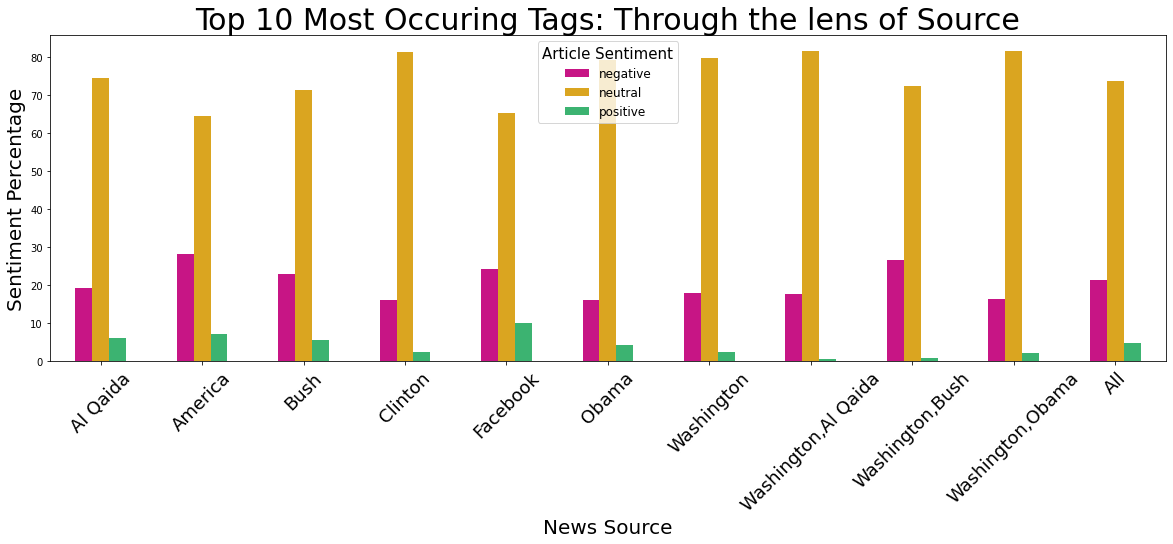

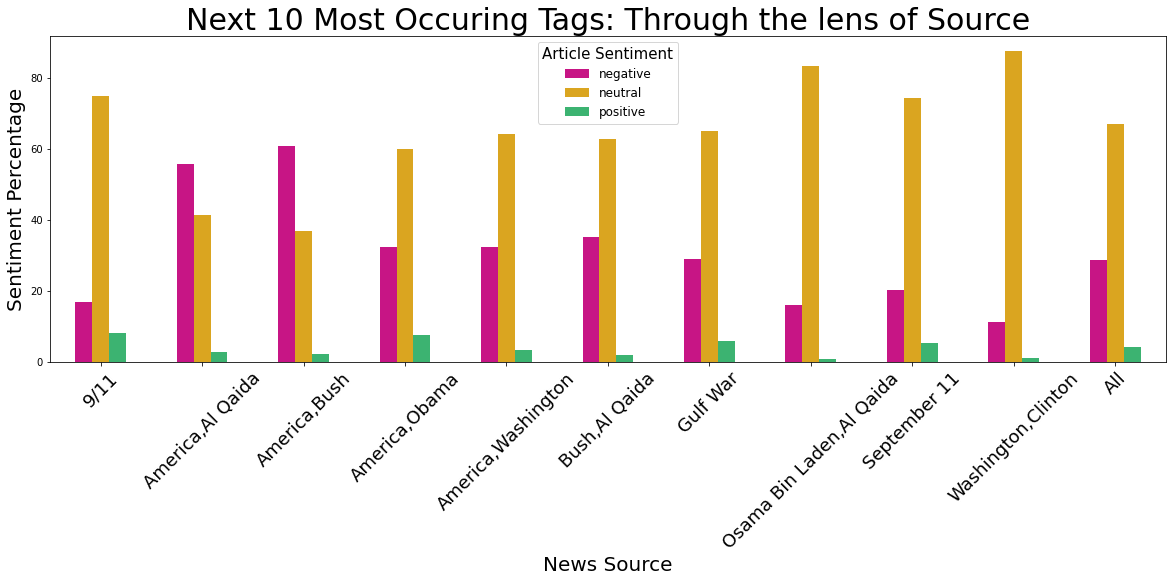

In [17]:
plt.rcParams["figure.figsize"] = (20, 6)

ax1= top_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])
ax2= next_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])

ax1.set_xlabel("News Source", fontsize=20)
ax2.set_xlabel("News Source", fontsize=20)

ax1.set_ylabel("Sentiment Percentage", fontsize=20)
ax2.set_ylabel("Sentiment Percentage", fontsize=20)

xlabels = ax1.get_xticklabels() 
ax1.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax2.get_xticklabels() 
ax2.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)

ax1.set_title('Top 10 Most Occuring Tags: Through the lens of Source', size=30)
ax1.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax2.set_title('Next 10 Most Occuring Tags: Through the lens of Source', size=30)
ax2.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

plt.show()


Statistical Test

- H0: The top 10 most frequently occuring tags and and text_label (sentiment) are independent of one another
- H1:  The top 10 most frequently occuring tags and and text_label (sentiment) are have a relationship

In [18]:
alpha =.05
#set alpha
observed = pd.crosstab(top_10.en_tags, top_10.text_label)

chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


Statistical Test

- H0: The next 10 most frequently occuring tags and and text_label (sentiment) are independent of one another
- H1:  The next 10 most frequently occuring tags and and text_label (sentiment) are have a relationship

In [19]:
alpha =.05

observed = pd.crosstab(next_10.en_tags, next_10.text_label)

chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


### Are there any sources that have change in sentiment based on president?

In [20]:
bush = df[(df['en_tags'] == 'Bush')]
obama = df[(df['en_tags'] == 'Obama')]
clinton = df[(df['en_tags'] == 'Clinton')]

presidents = pd.concat([bush, obama, clinton])
#dfs for presidents

In [27]:
bush = df[(df['text_label'] != 'False')]
obama = df[(df['text_label'] != 'False')]
clinton = df[(df['text_label'] != 'False')]

In [28]:
bush.text_label.value_counts(normalize = True)
#percentage of sentiment

neutral     0.730097
negative    0.224639
positive    0.045264
Name: text_label, dtype: float64

In [29]:
obama.text_label.value_counts(normalize = True)
#percentage of sentiment

neutral     0.730097
negative    0.224639
positive    0.045264
Name: text_label, dtype: float64

In [30]:
clinton.text_label.value_counts(normalize = True)
#percentage of sentiment

neutral     0.730097
negative    0.224639
positive    0.045264
Name: text_label, dtype: float64

In [31]:
pres_perc = pd.crosstab(presidents.source, presidents.text_label, margins=True)
pres_perc = pres_perc.apply(lambda x: x / x['All'] * 100, axis=1)
pres_perc = pres_perc.drop(columns=['All'])

clinton_perc = pd.crosstab(clinton.source, clinton.text_label, margins=True)
clinton_perc = clinton_perc.apply(lambda x: x / x['All'] * 100, axis=1)
clinton_perc = clinton_perc.drop(columns=['All'])

bush_perc = pd.crosstab(bush.source, bush.text_label, margins=True)
bush_perc = bush_perc.apply(lambda x: x / x['All'] * 100, axis=1)
bush_perc = bush_perc.drop(columns=['All'])

obama_perc = pd.crosstab(obama.source, obama.text_label, margins=True)
obama_perc = obama_perc.apply(lambda x: x / x['All'] * 100, axis=1)
obama_perc = obama_perc.drop(columns=['All'])

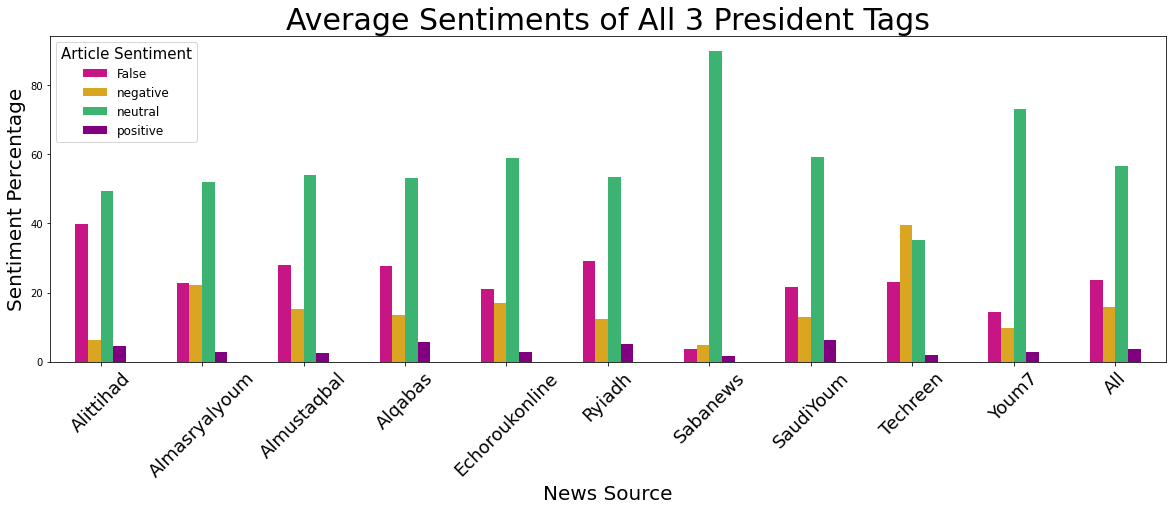

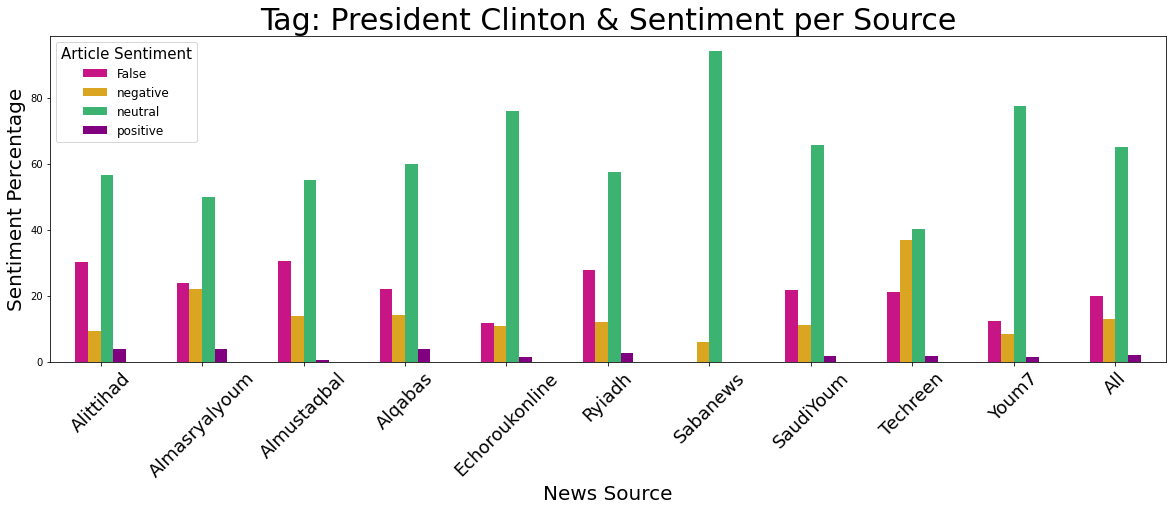

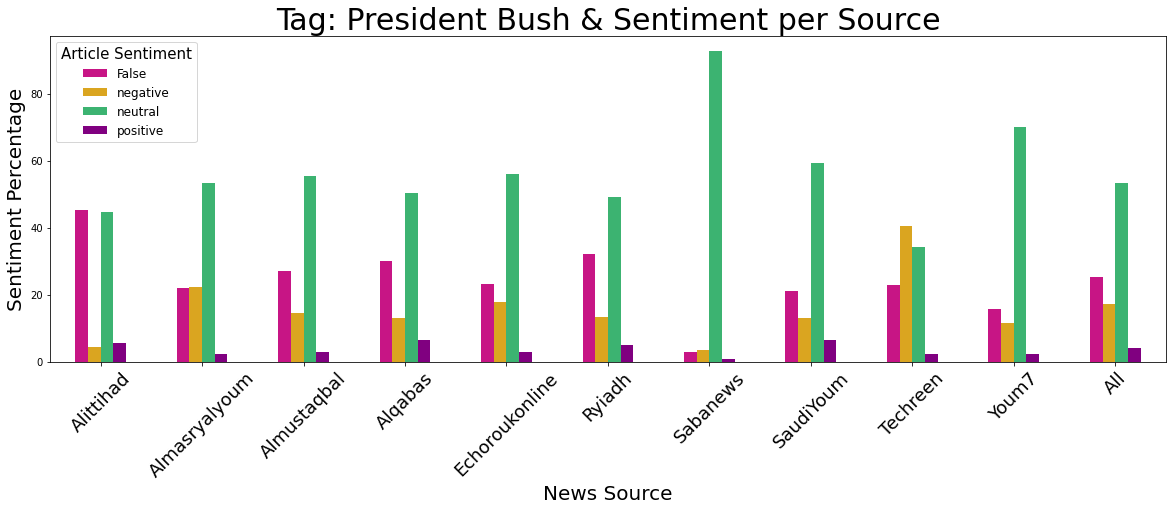

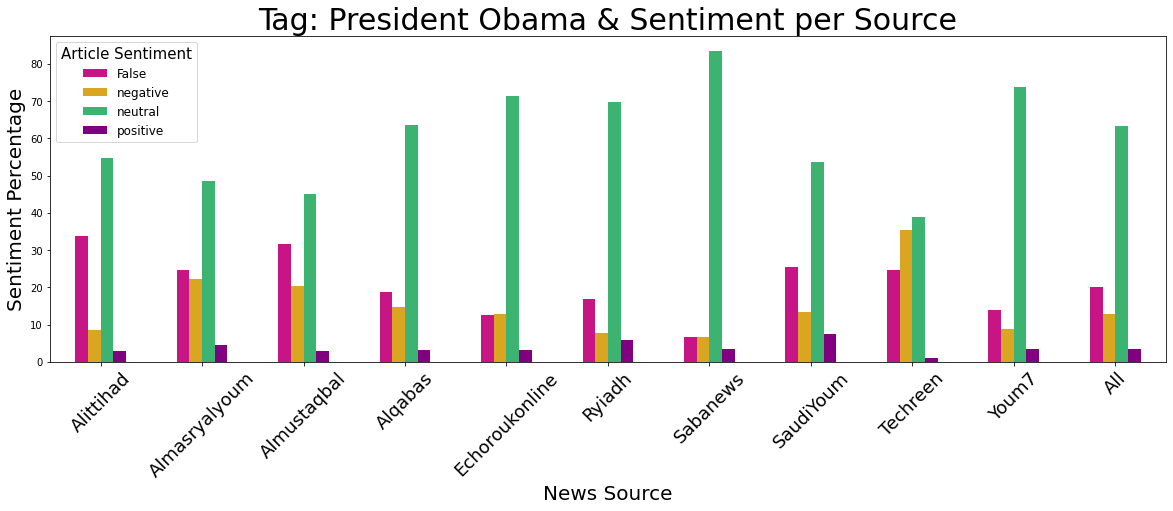

In [26]:
plt.rcParams["figure.figsize"] = (20, 6)

ax1= pres_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])
ax2= clinton_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])
ax3= bush_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])
ax4= obama_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen', 'purple'])

ax1.set_xlabel("News Source", fontsize=20)
ax2.set_xlabel("News Source", fontsize=20)
ax3.set_xlabel("News Source", fontsize=20)
ax4.set_xlabel("News Source", fontsize=20)

ax1.set_ylabel("Sentiment Percentage", fontsize=20)
ax2.set_ylabel("Sentiment Percentage", fontsize=20)
ax3.set_ylabel("Sentiment Percentage", fontsize=20)
ax4.set_ylabel("Sentiment Percentage", fontsize=20)


xlabels = ax1.get_xticklabels() 
ax1.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax2.get_xticklabels() 
ax2.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax3.get_xticklabels() 
ax3.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax4.get_xticklabels() 
ax4.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)


ax1.set_title('Average Sentiments of All 3 President Tags', size=30)
ax1.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax2.set_title('Tag: President Clinton & Sentiment per Source', size=30)
ax2.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax3.set_title('Tag: President Bush & Sentiment per Source', size=30)
ax3.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax4.set_title('Tag: President Obama & Sentiment per Source', size=30)
ax4.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)


plt.show()


Statistical Test

- H0: The US president tags and and text_label (sentiment) are independent of one another
- H1:  The US president tags and text_label (sentiment) are have a relationship

In [ ]:
alpha =.05

observed = pd.crosstab(presidents.en_tags, presidents.text_label)

chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

### Takeaways-
- Teshreen is more negative towards Bush than the other 2 presidents
- All sources averages are slightly more negative towards Buth
- Almustuqbal is noteably more negative towards Obama
- Most sources seem pretty consistent in sentiment towards presidents

### Explore relationships of the top 3 tags excluding presidents

In [ ]:
washington = df[(df['en_tags'] == 'Washington')]
al_q = df[(df['en_tags'] == 'Al Qaida')]
america = df[(df['en_tags'] == 'America')]

In [ ]:
al_q.text_label.value_counts(normalize = True)

In [ ]:
washington.text_label.value_counts(normalize = True)

In [ ]:
america.text_label.value_counts(normalize = True)

#### Interestingly, America has 9% more negative labels than Al Queda

In [ ]:
al_q.source.groupby(al_q.text_label).value_counts() 

In [ ]:
america_perc = pd.crosstab(america.source, america.text_label, margins=True)
america_perc = america_perc.apply(lambda x: x / x['All'] * 100, axis=1)
america_perc = america_perc .drop(columns=['All'])
america_perc
#look at this in percentages

In [ ]:
alq_perc = pd.crosstab(al_q.source, al_q.text_label, margins=True)
alq_perc = alq_perc.apply(lambda x: x / x['All'] * 100, axis=1)
alq_perc = alq_perc .drop(columns=['All'])
alq_perc

#look at this in percentages

In [ ]:
wash_perc = pd.crosstab(washington.source, washington.text_label, margins=True)
wash_perc = wash_perc.apply(lambda x: x / x['All'] * 100, axis=1)
wash_perc = wash_perc.drop(columns=['All'])
wash_perc

#look at this in percentages

In [ ]:
plt.rcParams["figure.figsize"] = (20, 6)

ax1 = wash_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen'])
ax2 = alq_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen'])
ax3 = america_perc.plot(kind='bar', color=['mediumvioletred', 'goldenrod', 'mediumseagreen'])

ax1.set_xlabel("News Source", fontsize=20)
ax2.set_xlabel("News Source", fontsize=20)
ax3.set_xlabel("News Source", fontsize=20)

ax1.set_ylabel("Sentiment Percentage", fontsize=20)
ax2.set_ylabel("Sentiment Percentage", fontsize=20)
ax3.set_ylabel("Sentiment Percentage", fontsize=20)

xlabels = ax1.get_xticklabels() 
ax1.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax2.get_xticklabels() 
ax2.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)
xlabels = ax3.get_xticklabels() 
ax3.set_xticklabels(labels=xlabels, rotation=45, fontsize=18)

ax1.set_title('Tag: Washington & Sentiment per Source', size=30)
ax1.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax2.set_title('Tag: Al Queda & Sentiment per Source', size=30)
ax2.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

ax3.set_title('Tag: America & Sentiment per Source', size=30)
ax3.legend(fontsize=12, title='Article Sentiment',title_fontsize=15)

fig.tight_layout()
fig.show()

- Interestingly, most sources have slightly more negative America articles than Al Queda (over all 10% more negative for America)
- A large margin favoring Al Queda is seen with Ryiadh and Techreen
- Techreen also has a standout high negative rate for washington
- washington compared with al queda total sentiment is very close. Other than Techreen, there isn't another source that has noteable increased negativity compared to Al Queda here. Ryiadh actually has a noteable increase in neutrals in this subset